In [1]:
from fastai.vision import * 
from fastai import * 
import pathlib

In [2]:
path = "/Users/ramamurthi/pet_projects/geoguessr/geoguessr/data/raw/"
path = pathlib.Path(path)
path

PosixPath('/Users/ramamurthi/pet_projects/geoguessr/geoguessr/data/raw')

In [4]:
train_path = path/'compressed_dataset'
train_path

PosixPath('/Users/ramamurthi/pet_projects/geoguessr/geoguessr/data/raw/compressed_dataset')

403.2016129032258


<Axes: ylabel='country'>

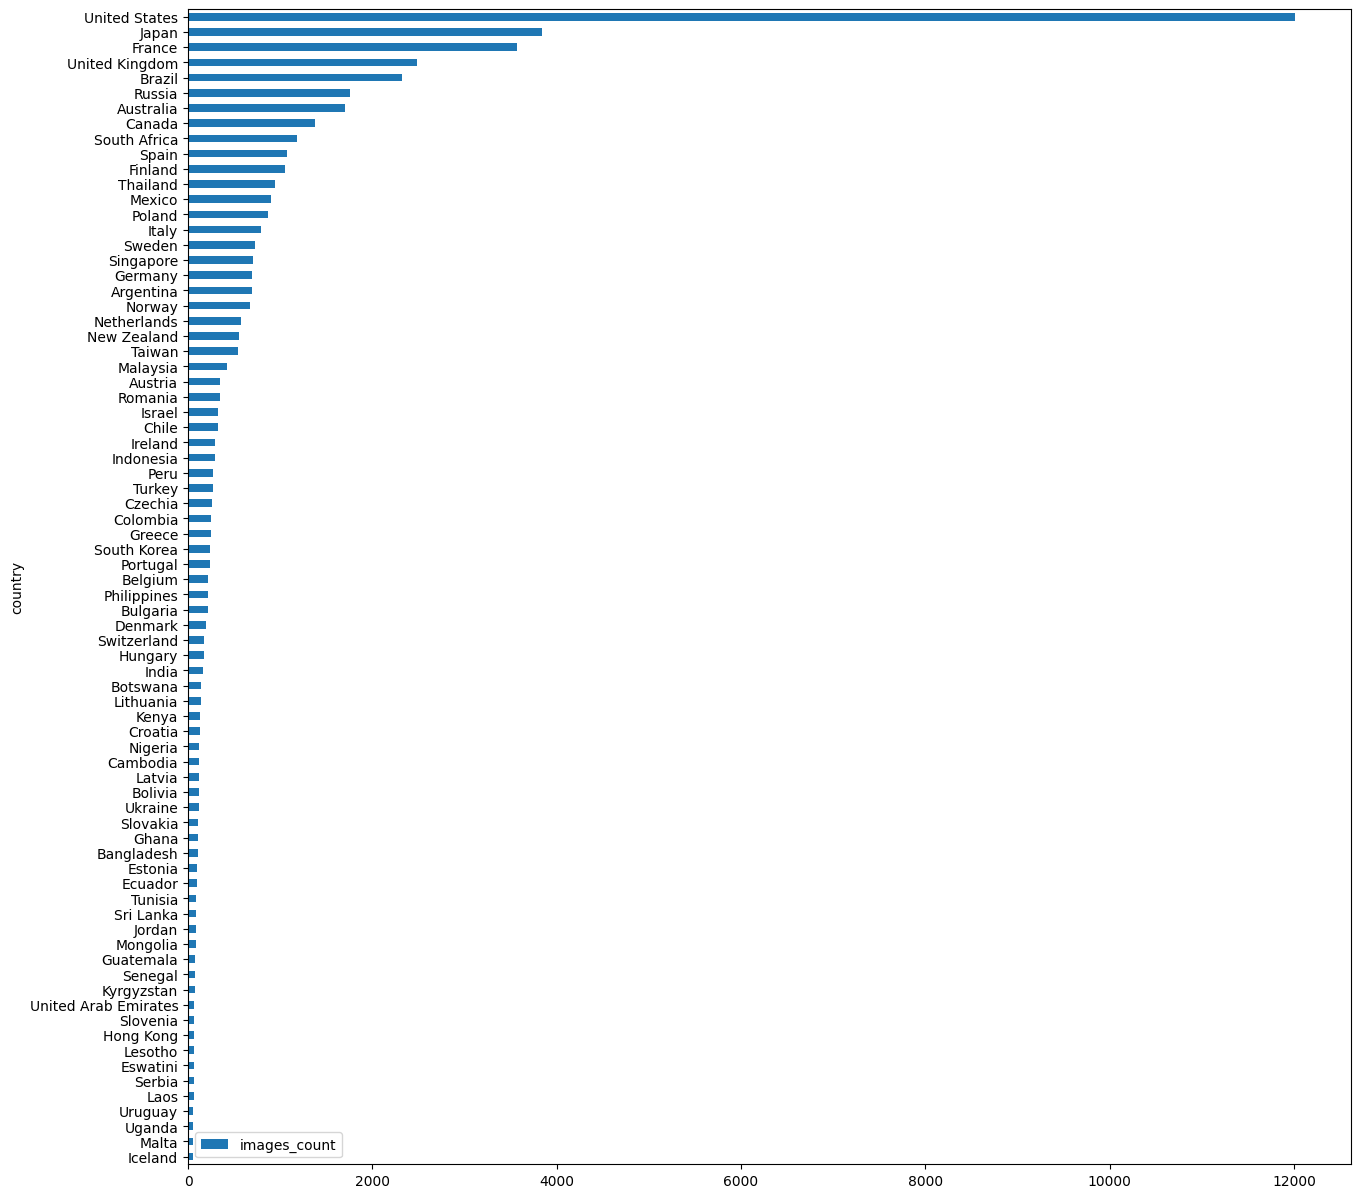

In [5]:
import matplotlib.pyplot as plt
import os
import pandas as pd
countries = os.listdir(train_path)
fig, ax = plt.subplots(figsize = (15,15))
country_count = {i:len(os.listdir(train_path/i)) for i in countries}
country_count_df = pd.DataFrame({'country':country_count.keys() , 'images_count' :country_count.values()})
country_count_df = country_count_df.sort_values(by='images_count')
print(country_count_df['images_count'].sum()/len(country_count_df['country'].unique()))
country_count_df_filtered = country_count_df[country_count_df['images_count']>50]
country_count_df_filtered.plot(kind = 'barh' , x = 'country', y = 'images_count' , ax = ax)


In [6]:
len(country_count_df) , len(country_count_df_filtered)

(124, 76)

In [7]:
filtered_countries = country_count_df_filtered['country'].unique()

In [8]:
from fastai.vision.data import ImageDataLoaders
from fastai.vision.all import * 
dls = ImageDataLoaders.from_folder(path, train='compressed_dataset',
                               valid_pct=0.2, seed=1,
                               item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=None, bs=64,
                               val_bs=64, shuffle=True,
                               device="mps")

In [9]:
dls.show_batch()

In [9]:
filtered_countries

array(['Iceland', 'Malta', 'Uganda', 'Uruguay', 'Laos', 'Serbia',
       'Eswatini', 'Lesotho', 'Hong Kong', 'Slovenia',
       'United Arab Emirates', 'Kyrgyzstan', 'Senegal', 'Guatemala',
       'Mongolia', 'Jordan', 'Sri Lanka', 'Tunisia', 'Ecuador', 'Estonia',
       'Bangladesh', 'Ghana', 'Slovakia', 'Ukraine', 'Bolivia', 'Latvia',
       'Cambodia', 'Nigeria', 'Croatia', 'Kenya', 'Lithuania', 'Botswana',
       'India', 'Hungary', 'Switzerland', 'Denmark', 'Bulgaria',
       'Philippines', 'Belgium', 'Portugal', 'South Korea', 'Greece',
       'Colombia', 'Czechia', 'Turkey', 'Peru', 'Indonesia', 'Ireland',
       'Chile', 'Israel', 'Romania', 'Austria', 'Malaysia', 'Taiwan',
       'New Zealand', 'Netherlands', 'Norway', 'Argentina', 'Germany',
       'Singapore', 'Sweden', 'Italy', 'Poland', 'Mexico', 'Thailand',
       'Finland', 'Spain', 'South Africa', 'Canada', 'Australia',
       'Russia', 'Brazil', 'United Kingdom', 'France', 'Japan',
       'United States'], dtype=object

Replacing all the countries with less than 50 images as unknown . In total , there are currently 76 categories in our dataset

In [10]:
from fastai.vision.all import * 
fnames = get_image_files(path/"compressed_dataset")
labels = [x.parent.name if x.parent.name in filtered_countries else 'UNKNOWN' for x in fnames ]

from fastai.vision.data import ImageDataLoaders
dls = ImageDataLoaders.from_lists(path, fnames, labels , valid_pct=0.2,bs=64,
                               val_bs=64, shuffle=True,
                               device="mps",
                               item_tfms=RandomResizedCrop(224, min_scale=0.5),
                               # batch_tfms=aug_transforms()
                               batch_tfms=None
                                )


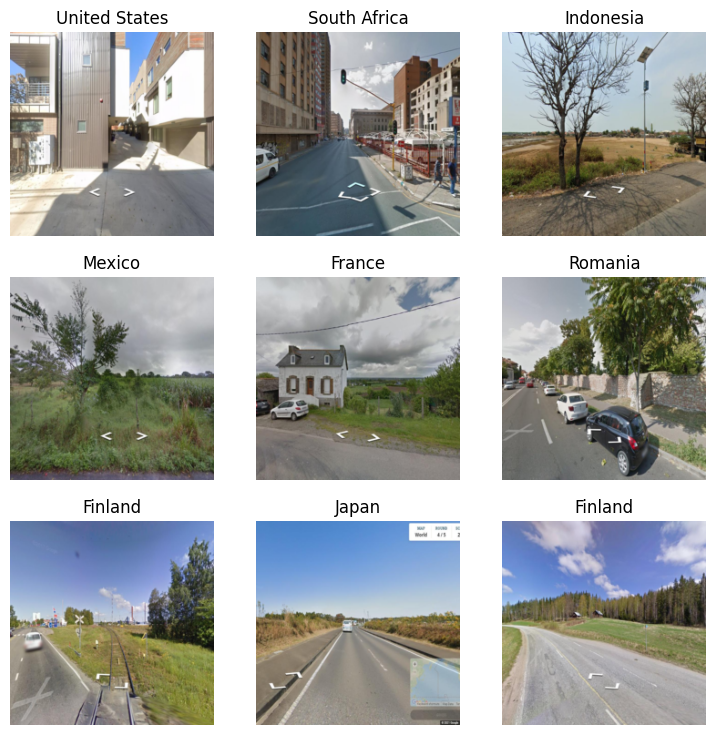

In [11]:
dls.show_batch()

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/Users/ramamurthi/pet_projects/geoguessr/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ramamurthi/pet_projects/geoguessr/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,3.132186,2.778549,0.676868,16:30


epoch,train_loss,valid_loss,error_rate,time
0,2.229879,2.133185,0.557556,19:26
1,1.809858,1.919127,0.510551,19:31
2,1.341259,1.856447,0.497750,19:16


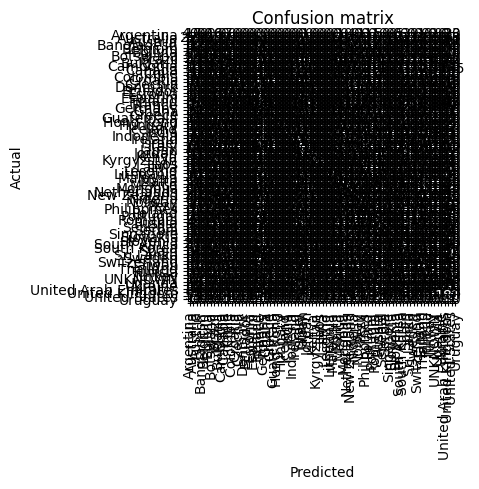

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

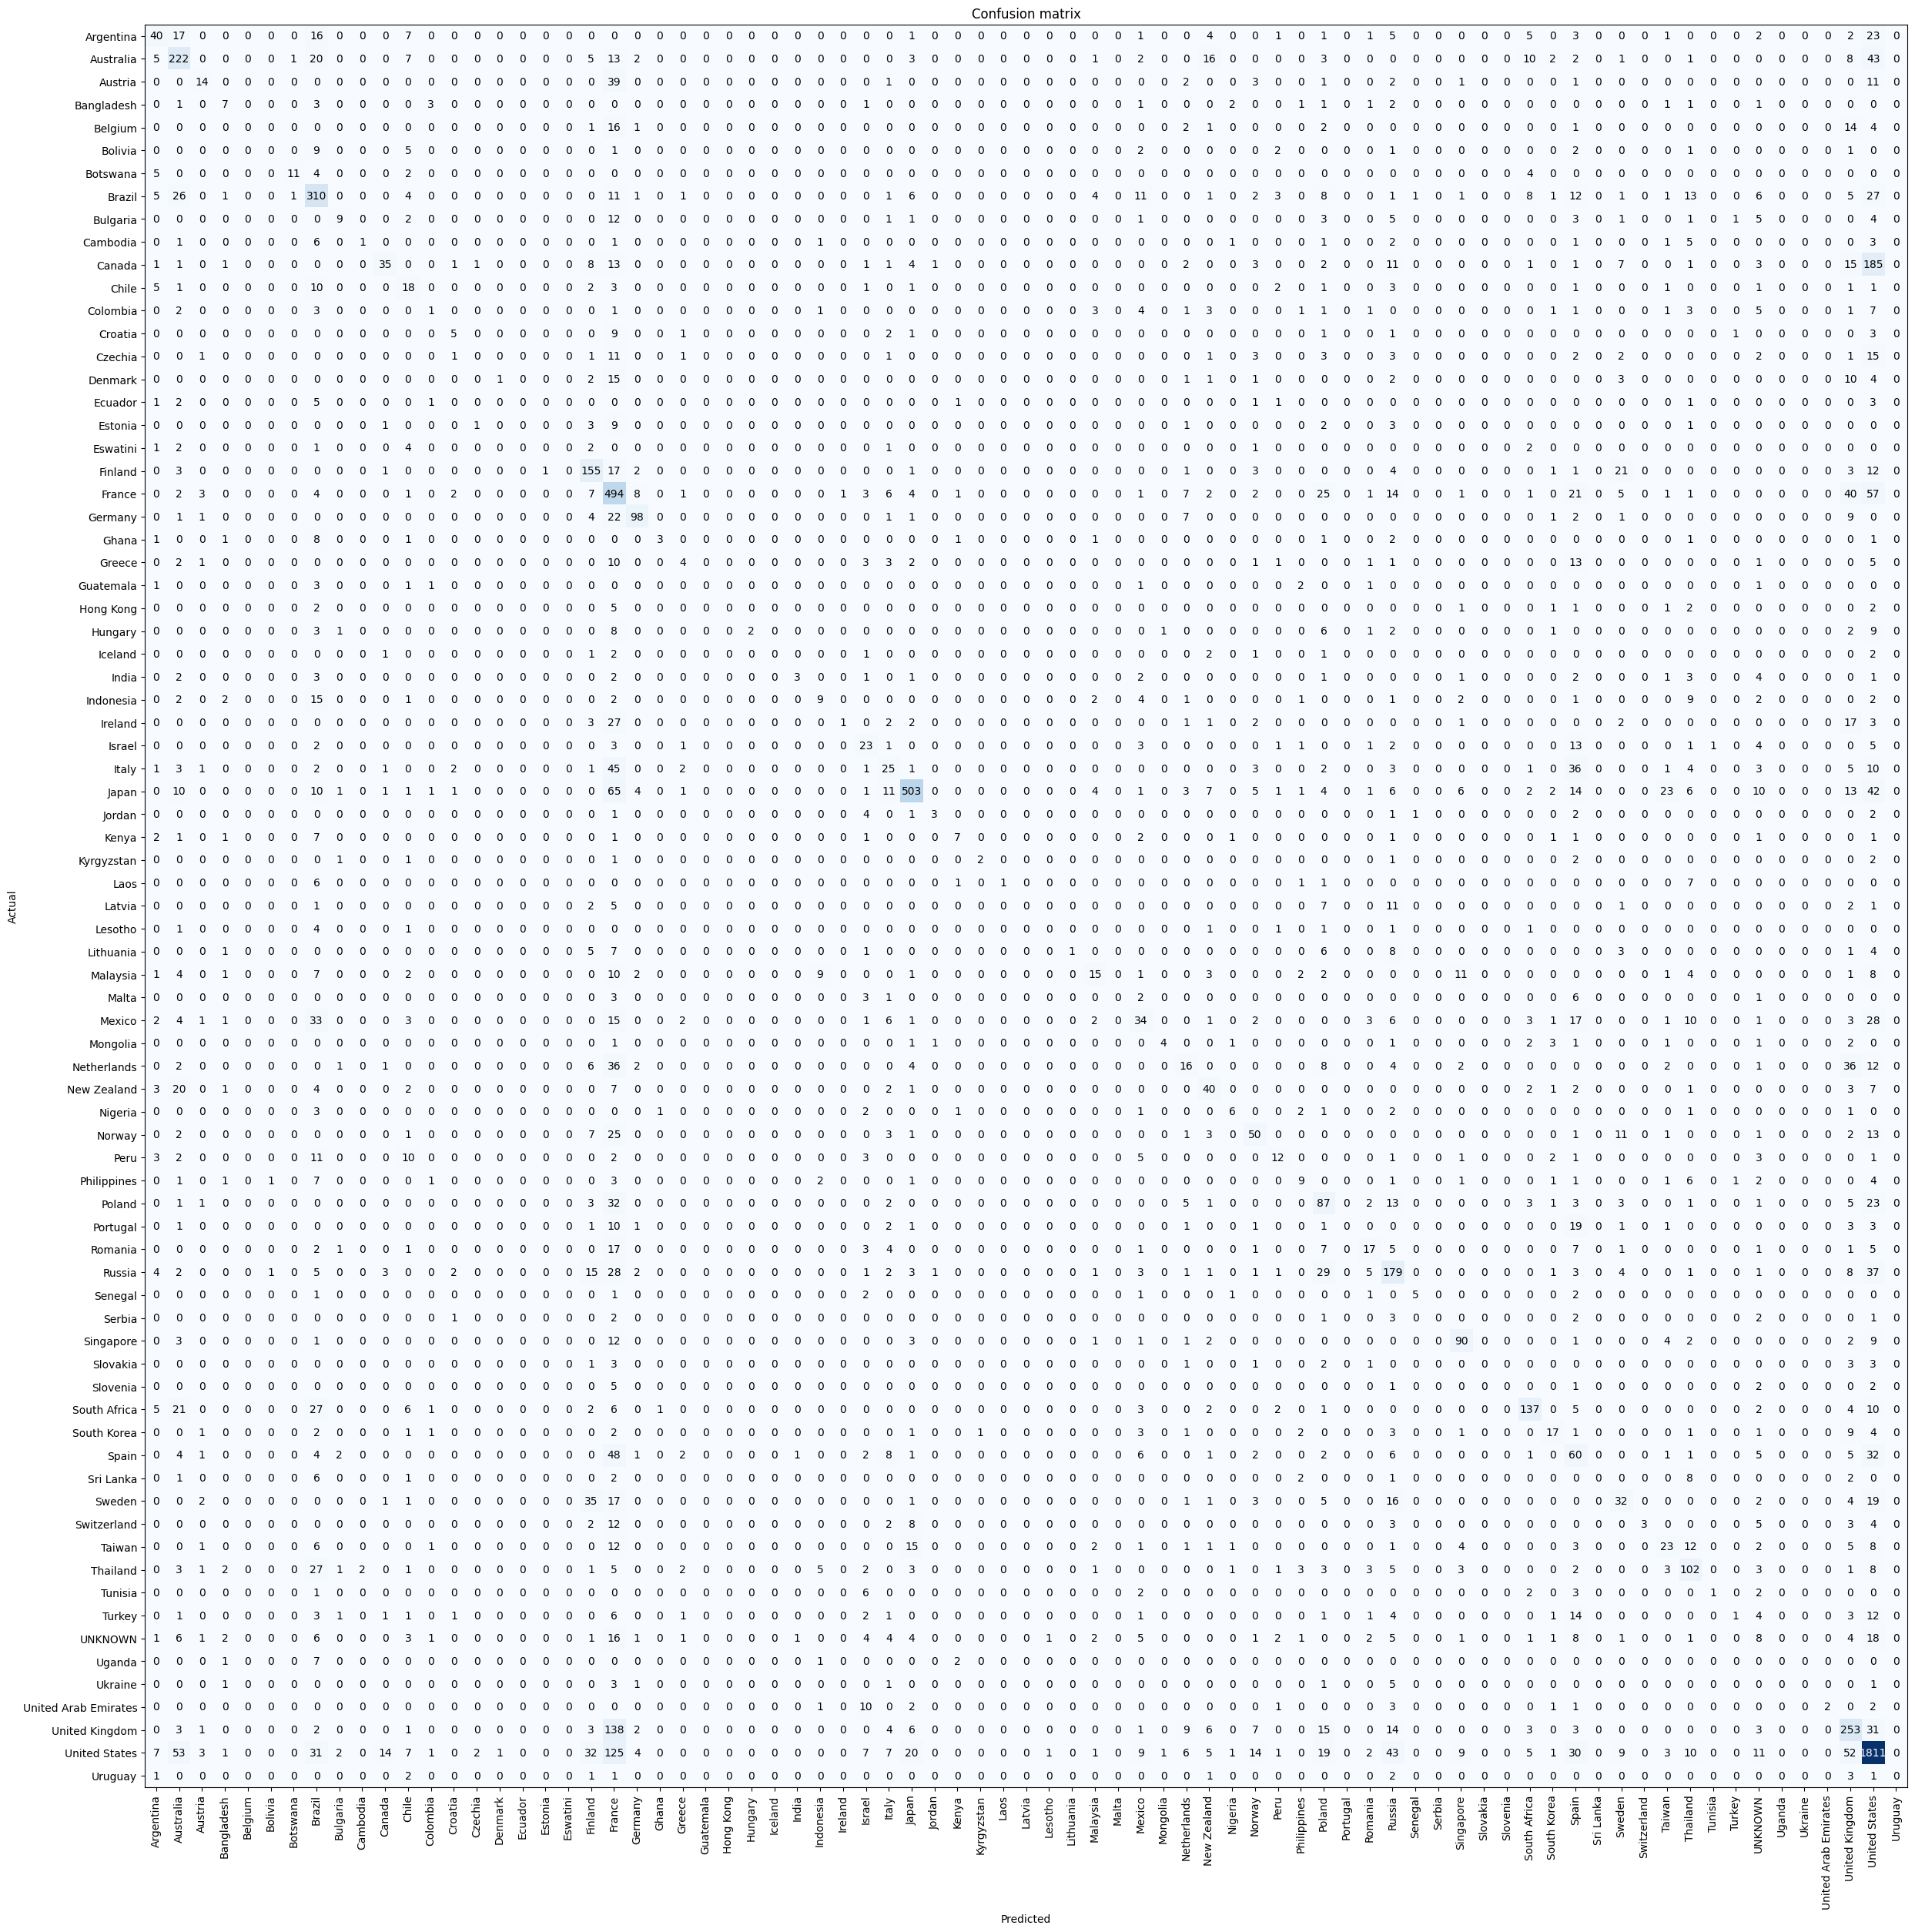

In [16]:
interp.plot_confusion_matrix(figsize=(25, 25))

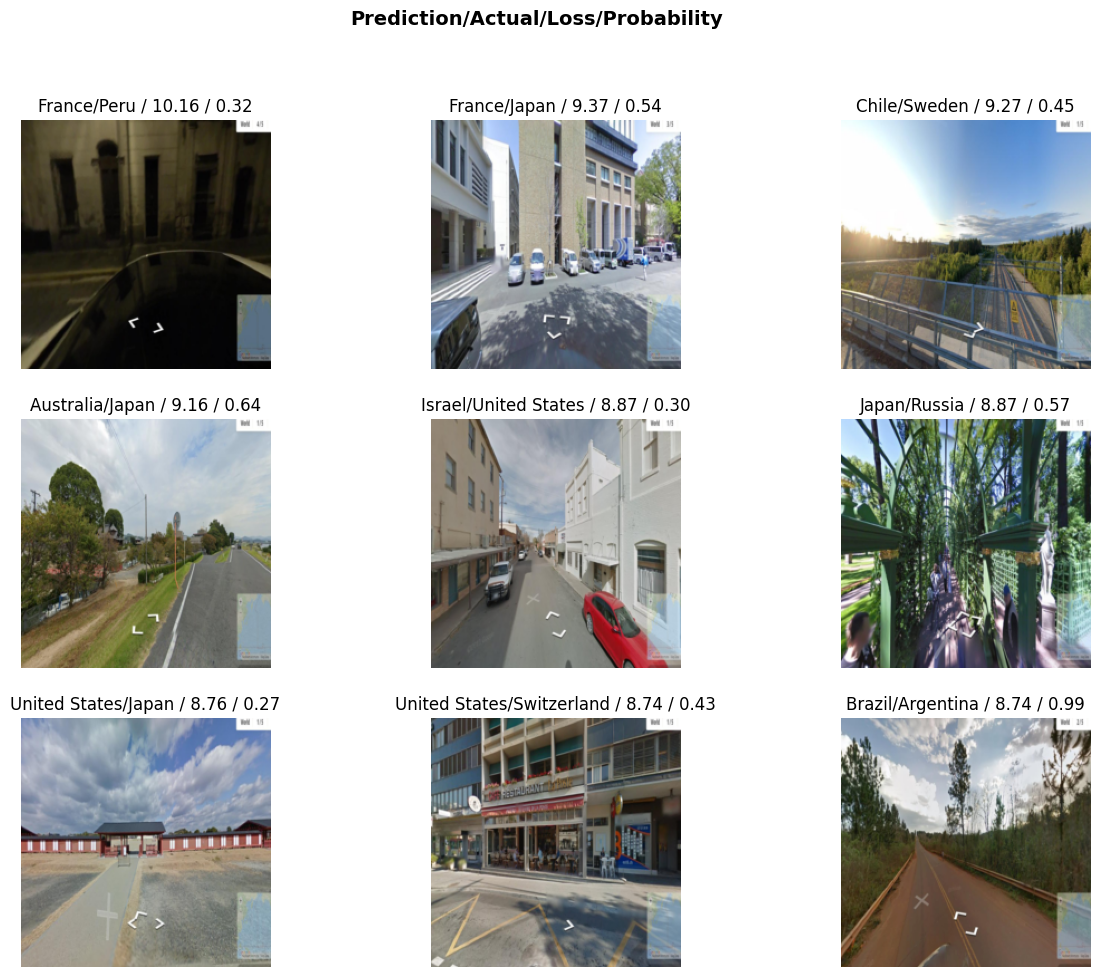

In [17]:
interp.plot_top_losses(9, figsize=(15,11))

In [20]:
path = "/Users/ramamurthi/pet_projects/geoguessr/geoguessr/data/model/"
path = pathlib.Path(path)
model_pth = path/"Kaggle_model_v1.pkl"
learn.export(model_pth)

In [4]:
from fastai.vision.all import * 

path = "/Users/ramamurthi/pet_projects/geoguessr/geoguessr/data/model/"
path = pathlib.Path(path)
model_pth = path/"Kaggle_model_v1.pkl"

exported_model = load_learner(model_pth)
exported_model


In [21]:
# Example 

city , index , preds = exported_model.predict('/Users/ramamurthi/pet_projects/geoguessr/geoguessr/data/raw/compressed_dataset/United States/canvas_1629257729.jpg')

In [22]:
df = pd.DataFrame( {'country':exported_model.dls.vocab , 'probabilities' : preds.numpy()} )
df.sort_values(by='probabilities', ascending=False)

,country,probabilities
75,United States,0.183630
54,Russia,0.157862
53,Romania,0.116165
20,France,0.061888
0,Argentina,0.048985
...,...,...
22,Ghana,0.000512
18,Eswatini,0.000450
71,Uganda,0.000421
73,United Arab Emirates,0.000396


In [25]:
pth = "/Users/ramamurthi/pet_projects/geoguessr/geoguessr/data/raw/compressed_dataset/United States/canvas_1629257729.jpg"

exported_model.predict(pth)

('United States',
 TensorBase(75),
 TensorBase([0.0490, 0.0034, 0.0394, 0.0010, 0.0028, 0.0015, 0.0009, 0.0074,
             0.0145, 0.0012, 0.0483, 0.0038, 0.0064, 0.0041, 0.0114, 0.0009,
             0.0028, 0.0041, 0.0005, 0.0017, 0.0619, 0.0017, 0.0005, 0.0088,
             0.0067, 0.0002, 0.0256, 0.0008, 0.0011, 0.0042, 0.0013, 0.0040,
             0.0060, 0.0051, 0.0020, 0.0021, 0.0049, 0.0015, 0.0036, 0.0008,
             0.0061, 0.0072, 0.0025, 0.0247, 0.0019, 0.0025, 0.0042, 0.0007,
             0.0007, 0.0009, 0.0110, 0.0310, 0.0032, 0.1162, 0.1579, 0.0006,
             0.0111, 0.0007, 0.0218, 0.0020, 0.0011, 0.0029, 0.0047, 0.0006,
             0.0022, 0.0013, 0.0029, 0.0092, 0.0011, 0.0031, 0.0100, 0.0004,
             0.0132, 0.0004, 0.0043, 0.1836, 0.0039]))

In [28]:
# Imports PIL module 
from PIL import Image
  
# open method used to open different extension image file
im = Image.open(pth) 
im.show()
  


In [27]:
exported_model.predict(im)

AttributeError: 'NoneType' object has no attribute 'crop'

In [29]:
from geoguessr import DIR_DATA
DIR_UPLOADS = DIR_DATA.joinpath("uploads")
img_path = DIR_UPLOADS.joinpath('test.jpg')
im.save(img_path)

In [30]:
exported_model.predict(img_path)

('United States',
 TensorBase(75),
 TensorBase([0.0492, 0.0034, 0.0394, 0.0010, 0.0029, 0.0016, 0.0009, 0.0074,
             0.0145, 0.0012, 0.0475, 0.0038, 0.0064, 0.0042, 0.0115, 0.0009,
             0.0028, 0.0041, 0.0005, 0.0017, 0.0623, 0.0017, 0.0005, 0.0089,
             0.0067, 0.0002, 0.0258, 0.0008, 0.0011, 0.0043, 0.0013, 0.0040,
             0.0060, 0.0051, 0.0020, 0.0022, 0.0049, 0.0015, 0.0036, 0.0009,
             0.0062, 0.0072, 0.0026, 0.0246, 0.0019, 0.0025, 0.0042, 0.0008,
             0.0007, 0.0009, 0.0111, 0.0312, 0.0032, 0.1164, 0.1582, 0.0006,
             0.0112, 0.0007, 0.0219, 0.0020, 0.0011, 0.0030, 0.0047, 0.0006,
             0.0022, 0.0013, 0.0029, 0.0092, 0.0011, 0.0031, 0.0100, 0.0004,
             0.0132, 0.0004, 0.0044, 0.1820, 0.0039]))

In [31]:
df

,country,probabilities
0,Argentina,0.05
1,Australia,0.00
2,Austria,0.04
3,Bangladesh,0.00
4,Belgium,0.00
...,...,...
72,Ukraine,0.01
73,United Arab Emirates,0.00
74,United Kingdom,0.00
75,United States,0.18


In [33]:
df.loc[1]['country']



'Australia'